# Unsupervised capstone 

In this assignment we will use text corpora from project gutenburg. The objective is to generate features using unsupervised learning methods, predict the authors using supervised learning models, and create clusters and compare how the authors are clustered.

In [1]:
# imports 
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import time
from sklearn import metrics

from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
# download package
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Omistaja\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [3]:
# import corpus
from nltk.corpus import gutenberg, stopwords

In [4]:
# see all files
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [5]:
# get file as paragraphs and assign to book title
emma = gutenberg.paras('austen-emma.txt')
leaves = gutenberg.paras('whitman-leaves.txt')
moby = gutenberg.paras('melville-moby_dick.txt')
stories = gutenberg.paras('bryant-stories.txt')
busterbrown = gutenberg.paras('burgess-busterbrown.txt')
alice = gutenberg.paras('carroll-alice.txt')
ball = gutenberg.paras('chesterton-ball.txt')
parents = gutenberg.paras('edgeworth-parents.txt')
bible = gutenberg.paras('bible-kjv.txt')
hamlet = gutenberg.paras('shakespeare-hamlet.txt')

In [6]:
# Group into sentences.
alice_paras = [[para, "Carroll"] for para in alice]
emma_paras = [[para, 'Austen'] for para in emma]
leaves_paras = [[para, 'Whitman'] for para in leaves]
moby_paras = [[para, 'Melville'] for para in moby]
stories_paras = [[para, 'Bryant'] for para in stories]
busterbrown_paras = [[para, 'Burgess'] for para in busterbrown]
ball_paras = [[para, 'Chesterton'] for para in ball]
parents_paras = [[para, 'Edgeworth'] for para in parents]
bible_paras = [[para, 'KJV'] for para in bible]
hamlet_paras = [[para, 'Shakespeare'] for para in hamlet]


# Combine the sentences from the two novels into one data frame.
paragraphs = pd.DataFrame(alice_paras + emma_paras + leaves_paras + moby_paras + stories_paras + busterbrown_paras + 
                          ball_paras + parents_paras + bible_paras + hamlet_paras)


In [7]:
#preview 
paragraphs.tail(10)

,0,1
40799,"[[Ham, .], [O, I, dye, Horatio, :, The, potent...",Shakespeare
40800,[[Dyes]],Shakespeare
40801,"[[Hora, .], [Now, cracke, a, Noble, heart, :, ...",Shakespeare
40802,"[[Fortin, .], [Where, is, this, sight, ?], [Ho...",Shakespeare
40803,"[[For, .], [His, quarry, cries, on, hauocke, ....",Shakespeare
40804,"[[Amb, .], [The, sight, is, dismall, ,, And, o...",Shakespeare
40805,"[[For, .], [Let, vs, hast, to, heare, it, ,, A...",Shakespeare
40806,"[[For, .], [Let, foure, Captaines, Beare, Haml...",Shakespeare
40807,"[[Exeunt, .], [Marching, :, after, the, which,...",Shakespeare
40808,"[[FINIS, .], [The, tragedie, of, HAMLET, ,, Pr...",Shakespeare


In [8]:
# inspect 
paragraphs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40809 entries, 0 to 40808
Data columns (total 2 columns):
0    40809 non-null object
1    40809 non-null object
dtypes: object(2)
memory usage: 637.7+ KB


In [9]:
# rename columns
paragraphs.columns = ['paragraph', 'Author']

In [11]:
# inspect
paragraphs.head()

,paragraph,Author
0,"[['[', 'Alice', ""'"", 's', 'Adventures', 'in', ...",Carroll
1,"[['CHAPTER', 'I', '.'], ['Down', 'the', 'Rabbi...",Carroll
2,"[['Alice', 'was', 'beginning', 'to', 'get', 'v...",Carroll
3,"[['So', 'she', 'was', 'considering', 'in', 'he...",Carroll
4,"[['There', 'was', 'nothing', 'so', 'VERY', 're...",Carroll


In [13]:
# we'll use stop words and stemmer to parse the paragraphs
stemmer = SnowballStemmer('english')
words = stopwords.words("english")

In [14]:
# clean our text data by applying the tools above and also keeping only characters A-Z  
paragraphs['paragraph'] = paragraphs['paragraph'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [15]:
#preview
paragraphs.head()

,paragraph,Author
0,alic adventur wonderland lewi carrol,Carroll
1,chapter i down rabbit hole,Carroll
2,alic begin get tire sit sister bank noth twice...,Carroll
3,so consid mind well could hot day made feel sl...,Carroll
4,there noth veri remark alic think veri much wa...,Carroll


In [16]:
# keep paragraphs with 10 characters or more
paragraphs_long = pd.DataFrame(paragraphs[paragraphs['paragraph'].apply(lambda x: len(x.split(' ')) > 10)])

In [17]:
paragraphs_long.head()

,paragraph,Author
2,alic begin get tire sit sister bank noth twice...,Carroll
3,so consid mind well could hot day made feel sl...,Carroll
4,there noth veri remark alic think veri much wa...,Carroll
6,the rabbit hole went straight like tunnel way ...,Carroll
7,either well deep fell slowli plenti time went ...,Carroll


In [18]:
paragraphs_long.paragraph.dtype

dtype('O')

In [19]:
paragraphs_long.shape

(28149, 2)

In [20]:
# sample paragraph
print(paragraphs_long.paragraph[3957])

flow river flow flood tide ebb ebb tide frolic crest scallop edg wave gorgeous cloud sunset drench splendor men women generat cross shore shore countless crowd passeng stand tall mast mannahatta stand beauti hill brooklyn throb baffl curious brain throw question answer suspend everywher etern float solut gaze love thirst eye hous street public assembl sound voic young men loud music call nighest name live old life play part look back actor actress play old role role great small accord one make consid perus whether i may unknown way look upon be firm rail river support lean idl yet hast hast current fli sea bird fli sideway wheel larg circl high air receiv summer sky water faith hold till downcast eye time take diverg fine spoke light shape head one head sunlit water come ship lower bay pass white sail schooner sloop lighter flaunt away flag nation duli lower sunset burn high fire foundri chimney cast black shadow nightfal cast red yellow light top hous appear henceforth indic you neces

In [22]:
# reset index
paragraphs_long=paragraphs_long.reset_index()

In [23]:
# drop index column
paragraphs_long=paragraphs_long.drop(['index'],axis=1)

In [24]:
# inspect
paragraphs_long.head()

,paragraph,Author
0,alic begin get tire sit sister bank noth twice...,Carroll
1,so consid mind well could hot day made feel sl...,Carroll
2,there noth veri remark alic think veri much wa...,Carroll
3,the rabbit hole went straight like tunnel way ...,Carroll
4,either well deep fell slowli plenti time went ...,Carroll


In [25]:
#check data type
paragraphs_long.dtypes

paragraph    object
Author       object
dtype: object

KJV            17002
Edgeworth       2473
Melville        2057
Whitman         1904
Austen          1810
Chesterton      1067
Bryant           760
Carroll          455
Shakespeare      434
Burgess          187
Name: Author, dtype: int64
Number of Paragraphs by Authors


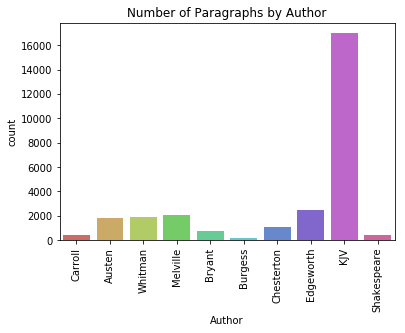

In [26]:
# Display class counts
print(paragraphs_long.Author.value_counts())
print('Number of Paragraphs by Authors')

sns.countplot(x='Author', data=paragraphs_long, palette='hls')
plt.title('Number of Paragraphs by Author')
plt.xticks(rotation=90)
plt.show()

We're not looking for exactly balanced class groups but, KJV has a much higher paragraph count than the rest and to avoid the whole signal being dominated by it, we'll reduce it to a much closer count. 

KJV            3000
Edgeworth      2473
Melville       2057
Whitman        1904
Austen         1810
Chesterton     1067
Bryant          760
Carroll         455
Shakespeare     434
Burgess         187
Name: Author, dtype: int64
KJV class downsampled


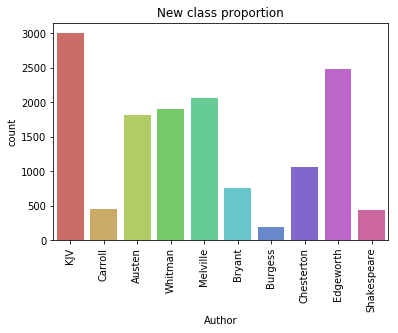

In [27]:
#Import module and resampling 

from sklearn.utils import resample

# Separate majority and minority classes
paragraphs_long_majority = paragraphs_long[paragraphs_long.Author=='KJV']
paragraphs_long_minority = paragraphs_long[paragraphs_long.Author!='KJV']
 
# Downsample majority overall class
paragraphs_long_majority_downsampled = resample(paragraphs_long_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3000,     # Just higher than others as the length of each paragraph is smaller
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority overall class
paragraphs_final = pd.concat([paragraphs_long_majority_downsampled, paragraphs_long_minority])
 
# Display new class counts
print(paragraphs_final.Author.value_counts())
print('KJV class downsampled')

sns.countplot(x='Author', data=paragraphs_final, palette='hls')
plt.title('New class proportion')
plt.xticks(rotation=90)
plt.show()

In [28]:
# check for missing values
paragraphs_final.isnull().sum()

paragraph    0
Author       0
dtype: int64

In [30]:
# reset index again
paragraphs_final=paragraphs_final.reset_index()

In [31]:
# reset index again
paragraphs_final=paragraphs_final.drop(['index'],axis=1)

In [32]:
paragraphs_final.head()

,paragraph,Author
0,and father refus said i know son i know also s...,KJV
1,for five thousand men and said discipl make si...,KJV
2,and aros prophet sinc israel like unto mose lo...,KJV
3,in first year darius son ahasuerus seed mede m...,KJV
4,and border drawn thenc compass corner sea sout...,KJV


In [33]:
# define dependent and independent variables
X = paragraphs_final['paragraph']
Y = paragraphs_final['Author']

In [35]:
# inspect 
X.head()

0    and father refus said i know son i know also s...
1    for five thousand men and said discipl make si...
2    and aros prophet sinc israel like unto mose lo...
3    in first year darius son ahasuerus seed mede m...
4    and border drawn thenc compass corner sea sout...
Name: paragraph, dtype: object

In [36]:
# split the data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [37]:
# inspect
X_train.shape

(9902,)

In [38]:
# inspect
X_train.head()

4053     yes entir entir choic colonel mrs campbel thin...
12554    will i shall much oblig said ben away went boy...
108      and went children israel priest levit singer p...
6497     of state poet equabl man not thing grotesqu ec...
4874     no said emma reckon low a conundrum mr weston ...
Name: paragraph, dtype: object

## Unsupervised feature generation using tf-idf 

In [39]:
# import module and initialize vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [40]:
# fit and transform 
X_train_tf=vectorizer.fit_transform(X_train)
X_test_tf=vectorizer.transform(X_test)

In [41]:
# inspect shape
print(X_train.shape)
print(X_train_tf.shape)

(9902,)
(9902, 10136)


## Supervised models with tfi-df features.

Now we will use supervised learning thechniques to predict authors using features we generated using unsupervised method

## KNN

In [43]:
# Fit the data to knn model 
start_time = time.clock()
neigh = KNeighborsClassifier(n_neighbors=1000, weights='distance')

neigh.fit(X_train_tf, y_train)
y_knn = neigh.predict(X_test_tf)

print('training set score', cross_val_score(neigh, X_train_tf, y_train, cv=5))
print('\ntest set score', cross_val_score(neigh, X_test_tf, y_test, cv=5))


#print('Training set score:', neigh.score(X_train_tf, y_train))
#print('\nTest set score:', neigh.score(X_test_tf, y_test))

#score_knn = cross_val_score(neigh, X, Y, cv=10)
#print(score_knn)

print("--- %s seconds ---" % (time.clock() - start_time))

training set score [0.65156093 0.64127144 0.63838384 0.65098634 0.63682347]

test set score [0.54449649 0.57344301 0.57294118 0.56737589 0.57345972]
--- 9.316364351613036 seconds ---


The predictions are only a little better than random guess. KNN looks unsutable for high dimentional data. We'll next see logistics regression models as the regularization parameters might help with high dimentionality.  

## Logistics regression

In [44]:
# Binary classification using logistics 
from sklearn.linear_model import LogisticRegression
start_time = time.clock()
logreg = LogisticRegression()
logreg.fit(X_train_tf, y_train)

# Predict using the test set
y_logreg = logreg.predict(X_test_tf)

# Evaluations
print('training set score', cross_val_score(logreg, X_train_tf, y_train, cv=5))
print('\ntest set score', cross_val_score(logreg, X_test_tf, y_test, cv=5))

print("--- %s seconds ---" % (time.clock() - start_time))

training set score [0.87311178 0.87588295 0.89393939 0.88517956 0.86899342]

test set score [0.81498829 0.8213866  0.82235294 0.83451537 0.83412322]
--- 4.269431811539384 seconds ---


The cross validation scores are high and consistent along training and test sets. 

## Lasso

In [45]:
start_time = time.clock()
lasso = LogisticRegression(penalty='l1')
lasso.fit(X_train_tf, y_train)

y_lasso = lasso.predict(X_test_tf)

# Evaluations
print('training set score', cross_val_score(lasso, X_train_tf, y_train, cv=5))
print('\ntest set score', cross_val_score(lasso, X_test_tf, y_test, cv=5))

print("--- %s seconds ---" % (time.clock() - start_time))

training set score [0.83635448 0.83350151 0.85555556 0.84269095 0.83055134]

test set score [0.77868852 0.77320799 0.78705882 0.77895981 0.76303318]
--- 2.9938918321815464 seconds ---


The 'l1' penalty doesn't seem to improve the score from the vanila logistics regression model. 

## Random Forest

In [46]:
start_time = time.clock()
forest_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150, 200, 300, 500]}
forest = GridSearchCV(ensemble.RandomForestClassifier(), forest_para, cv=5)
grid_fit_forest = forest.fit(X_train_tf, y_train)

best_forest = grid_fit_forest.best_estimator_
y_forest = best_forest.predict(X_test_tf)

print('training set score', cross_val_score(best_forest, X_train_tf, y_train, cv=5))
print('\ntest set score', cross_val_score(best_forest, X_test_tf, y_test, cv=5))

print("--- %s seconds ---" % (time.clock() - start_time))

training set score [0.77240685 0.75580222 0.77474747 0.7516439  0.72736469]

test set score [0.73770492 0.73678026 0.75176471 0.71158392 0.73578199]
--- 154.59453345433616 seconds ---


Logistics regression is the clear winner and we have demonstrated that features generated with unsupervised method can be used to fit supervised models and get a prediction with a high accuracy. 

In [102]:
# the first 20 predictions
print(y_logreg[:20])

['Chesterton' 'Melville' 'Whitman' 'KJV' 'Edgeworth' 'Whitman' 'Whitman'
 'Edgeworth' 'Edgeworth' 'Austen' 'Whitman' 'Edgeworth' 'Whitman'
 'Melville' 'Whitman' 'Melville' 'Melville' 'KJV' 'Edgeworth' 'Edgeworth']


## Clustering the paragraphs

### Dimentionality reduction using LSA

So Latent Semantic Analysis (LSA) is the process of applying PCA to a tf-idf term-document matrix. What we get, in the end, is clusters of terms that presumably reflect a topic. Each document will get a score for each topic, with higher scores indicating that the document is relevant to the topic. 

In [49]:
# Import modules
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize, Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 19704 to 2500.
svd= TruncatedSVD(2500)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tf)
X_test_lsa = lsa.fit_transform(X_test_tf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:5])




Percent variance captured by all components: 94.38085058825797
Component 0:
paragraph
the lord thi god rais unto thee prophet midst thee thi brethren like unto unto ye shall hearken accord thou desiredst lord thi god horeb day assembl say let hear voic lord god neither let see great fire i die                                                      0.429013
then went king david sat lord said who i o lord god hous thou hast brought hitherto and yet small thing thi sight o lord god thou hast spoken also thi servant hous great come and manner man o lord god and david say unto thee thou lord god knowest thi servant    0.405742
for coven i make hous israel day saith lord i put law mind write heart i god shall peopl and shall teach everi man neighbour everi man brother say know lord shall know least greatest                                                                                0.379364
seven day shalt thou keep solemn feast unto lord thi god place lord shall choos lord thi god shall bl

Most of the components above have paragraphs with low scores and all of them apear to come from KJV which is the bible. They seem to have the same theme and difficult to identify what characterstics each of them have.  

### Document similarity

The similarity matrix below shows low similarity between the documents

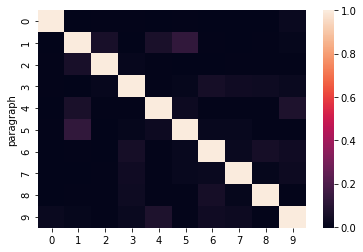

Key:
0 yes entir entir choic colonel mrs campbel think quit right recommend inde particular wish tri nativ air quit well usual late
1 will i shall much oblig said ben away went boy bow ornament green riband
2 and went children israel priest levit singer porter nethinim unto jerusalem seventh year artaxerx king
3 of state poet equabl man not thing grotesqu eccentr fail full return noth place good noth place bad he bestow everi object qualiti fit proport neither less he arbit divers key he equal age land he suppli want suppli check want check in peac speak spirit peac larg rich thrifti build popul town encourag agricultur art commerc light studi man soul health immort govern in war best backer war fetch artilleri good engin make everi word speak draw blood the year stray toward infidel withhold steadi faith he arguer judgment natur accept absolut he judg judg judg sun fail round helpless thing as see farthest faith his thought hymn prais thing in disput god etern silent he see etern less

In [50]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


No sign of similarity between the paragraphs.